In [3]:
# imporing required libraries
import librosa, librosa.display
import matplotlib.pyplot as plt
import soundfile
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [4]:
#extracting features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
            
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [5]:
#emotions present in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'angry', 'disgust', 'surprised']

In [6]:
#loading data with observed_emotions and extracting features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("./data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [7]:
# load happy and sad data
x_train,x_test,y_train,y_test=load_data()

In [8]:
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(921, 231)
Features extracted: 180


In [24]:
# build LR Model
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [25]:
# training model
model.fit(x_train,y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [26]:
# predicting for test data
y_pred=model.predict(x_test)

array([[28,  1,  5,  3,  3,  5],
       [ 0, 28,  5,  3,  1,  1],
       [ 4,  7, 20,  3,  5,  3],
       [ 4,  1,  4, 24,  7,  3],
       [ 4,  0,  4,  6, 18,  1],
       [ 1,  4,  6,  0,  3, 16]])

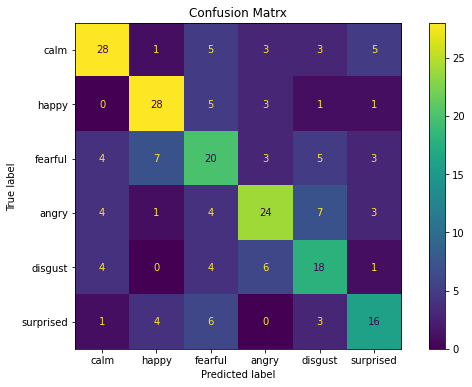

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(model, x_test, y_test, display_labels= observed_emotions, ax = ax)
disp.confusion_matrix

In [28]:
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred) * 100)

Accuracy:  58.00865800865801


In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.68      0.62      0.65        45
        calm       0.68      0.74      0.71        38
     disgust       0.45      0.48      0.47        42
     fearful       0.62      0.56      0.59        43
       happy       0.49      0.55      0.51        33
   surprised       0.55      0.53      0.54        30

    accuracy                           0.58       231
   macro avg       0.58      0.58      0.58       231
weighted avg       0.58      0.58      0.58       231

